In [1]:
# imports
import os
from os.path import join
import numpy as np
import pandas as pd
import json
import librosa
from pathlib import Path
import yaml
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt

import torch
from datasets import Dataset, DatasetDict
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Processor

In [2]:
torch.cuda.is_available()

True

## Prepare data and tokenizer

In [3]:
# load the pickle data file
with open('./pkl/magister_data_flac_16000_train.pkl', 'rb') as f:
    df_train = pickle.load(f)

with open('./pkl/magister_data_flac_16000_dev.pkl', 'rb') as f:
    df_dev = pickle.load(f)

In [4]:
df_train

,file,audio,text
0,./datasets/magister_data_flac_16000_finetune/t...,"{'array': [-0.00091552734, -0.0007324219, -0.0...",FCS GUNNERY BROADCAST POLICY SURFACE AND AIR F...
1,./datasets/magister_data_flac_16000_finetune/t...,"{'array': [-0.00012207031, 0.00018310547, 0.00...",ROGER
2,./datasets/magister_data_flac_16000_finetune/t...,"{'array': [0.0077209473, 0.009490967, 0.011291...",AGUN ENGAGE MISSILE NORTH AT TWO MILES
3,./datasets/magister_data_flac_16000_finetune/t...,"{'array': [-0.0057373047, -0.0053100586, -0.00...",G P M G PROVIDE ONE BOX TWO FIVE ZERO ROUNDS L...
4,./datasets/magister_data_flac_16000_finetune/t...,"{'array': [3.0517578e-05, -3.0517578e-05, -6.1...",OOW COME LEFT ZERO TWO ZERO INCREASE ONE TWO OOW
...,...,...,...
1813,./datasets/magister_data_flac_16000_finetune/t...,"{'array': [0.008239746, 0.011108398, 0.0139770...",TPS PWO CHECK COPY
1814,./datasets/magister_data_flac_16000_finetune/t...,"{'array': [0.0015563965, 0.0008544922, 0.00015...",AND FIRE ON PAC TARGET ZERO ZERO FOUR NINE K A...
1815,./datasets/magister_data_flac_16000_finetune/t...,"{'array': [0.2989502, 0.3025818, 0.3062439, 0....",# OW PWO COME LEFT TWO NINE ZERO WEPS THIS PWO...
1816,./datasets/magister_data_flac_16000_finetune/t...,"{'array': [3.0517578e-05, -0.00024414062, -0.0...",# ALL STATION # THIS PWO MISSIONS BRIEF AS FOL...


In [5]:
df_dev

,file,audio,text
0,./datasets/magister_data_flac_16000_finetune/d...,"{'array': [0.01727295, 0.01184082, 0.006408691...",FOXTROT ONE DELTA THIS IS ALFA FOUR QUEBEC SHO...
1,./datasets/magister_data_flac_16000_finetune/d...,"{'array': [0.0015258789, 0.001159668, 0.000793...",FOXTROT ONE DELTA THIS IS ALFA FOUR QUEBEC SHO...
2,./datasets/magister_data_flac_16000_finetune/d...,"{'array': [0.005645752, 0.004852295, 0.0040588...",ALFA FOUR QUEBEC # POSITIONING # FOR P A C RUN...
3,./datasets/magister_data_flac_16000_finetune/d...,"{'array': [0.001739502, 0.0017700195, 0.001831...",ALL IN THIS IS PWO INTEND CONTINUES FIRING NO ...
4,./datasets/magister_data_flac_16000_finetune/d...,"{'array': [0.0011291504, 0.0005493164, 0.0, 0....",FOXTROT ONE DELTA THIS IS ALFA FOUR QUEBEC COM...
...,...,...,...
355,./datasets/magister_data_flac_16000_finetune/d...,"{'array': [-0.0009460449, -0.0015563965, -0.00...",WEAPS TRANSMIT F C R ALL ROUND TRAINING FREQUE...
356,./datasets/magister_data_flac_16000_finetune/d...,"{'array': [0.0005187988, 0.000579834, 0.000671...",# COMMAND THIS IS BASE ON S O C CEASE IS # FOU...
357,./datasets/magister_data_flac_16000_finetune/d...,"{'array': [-0.0005187988, -0.00079345703, -0.0...",RESOLVE # ID AND INTENTION OF # UNKNOWN # STRE...
358,./datasets/magister_data_flac_16000_finetune/d...,"{'array': [0.0013122559, 0.0012817383, 0.00128...",I MAKE # U A ONE SEVEN FOUR # POSHOS U A ONE S...


In [6]:
# from now on load the data from the pickle file and not from the dataset class from huggingface

In [7]:
df_dev['file'][0]

'./datasets/magister_data_flac_16000_finetune/dev/11251/314114000/11251-314114000-0045.flac'

In [8]:
df_dev['audio'][0]['array'][:25]

array([ 0.01727295,  0.01184082,  0.00640869,  0.00616455,  0.00592041,
        0.00735474,  0.00881958,  0.00918579,  0.009552  ,  0.00881958,
        0.00811768,  0.00979614,  0.01147461,  0.01074219,  0.01000977,
        0.0083313 ,  0.00668335,  0.0062561 ,  0.00582886,  0.00094604,
       -0.00390625, -0.00979614, -0.01565552, -0.01123047, -0.0067749 ],
      dtype=float32)

In [9]:
# extract all characters available in the annotations
def extract_all_chars(batch):
    all_text = " ".join(batch["text"])
    vocab = list(set(all_text))
    return vocab

In [10]:
# extract characters from train dataset
vocabs_train = extract_all_chars(df_train)
print(len(vocabs_train))
vocabs_train

30


[' ',
 'A',
 'R',
 'U',
 'M',
 'Q',
 'G',
 'C',
 'X',
 'D',
 "'",
 'Y',
 'O',
 'F',
 'T',
 'H',
 'J',
 'I',
 'W',
 '#',
 'S',
 'N',
 'E',
 'P',
 '-',
 'L',
 'V',
 'B',
 'Z',
 'K']

In [11]:
# extract characters from train dataset
vocabs_dev = extract_all_chars(df_dev)
print(len(vocabs_dev))
vocabs_dev

29


[' ',
 'A',
 'R',
 'U',
 'M',
 'Q',
 'C',
 'G',
 'X',
 'D',
 "'",
 'Y',
 'O',
 'F',
 'T',
 'H',
 'J',
 'I',
 'W',
 '#',
 'S',
 'N',
 'E',
 'P',
 'L',
 'V',
 'B',
 'Z',
 'K']

In [12]:
# create a union of all distinct letters in the training and the dev datasets
vocab_list = list(set(vocabs_train) | set(vocabs_dev))
vocab_list

[' ',
 'A',
 'R',
 'U',
 'M',
 'Q',
 'C',
 'G',
 'X',
 'D',
 "'",
 'Y',
 'O',
 'F',
 'T',
 'H',
 'J',
 'I',
 'W',
 '#',
 'S',
 'N',
 'E',
 'P',
 '-',
 'L',
 'V',
 'B',
 'Z',
 'K']

In [13]:
# convert resulting list into an enumerated dictionary
vocab_dict = {v: k for k, v in enumerate(vocab_list)}
vocab_dict

{' ': 0,
 'A': 1,
 'R': 2,
 'U': 3,
 'M': 4,
 'Q': 5,
 'C': 6,
 'G': 7,
 'X': 8,
 'D': 9,
 "'": 10,
 'Y': 11,
 'O': 12,
 'F': 13,
 'T': 14,
 'H': 15,
 'J': 16,
 'I': 17,
 'W': 18,
 '#': 19,
 'S': 20,
 'N': 21,
 'E': 22,
 'P': 23,
 '-': 24,
 'L': 25,
 'V': 26,
 'B': 27,
 'Z': 28,
 'K': 29}

In [14]:
# replace space with a more visible character |
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]
vocab_dict

{'A': 1,
 'R': 2,
 'U': 3,
 'M': 4,
 'Q': 5,
 'C': 6,
 'G': 7,
 'X': 8,
 'D': 9,
 "'": 10,
 'Y': 11,
 'O': 12,
 'F': 13,
 'T': 14,
 'H': 15,
 'J': 16,
 'I': 17,
 'W': 18,
 '#': 19,
 'S': 20,
 'N': 21,
 'E': 22,
 'P': 23,
 '-': 24,
 'L': 25,
 'V': 26,
 'B': 27,
 'Z': 28,
 'K': 29,
 '|': 0}

In [15]:
# add the [UNK] and the [PAD] token
vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
print(len(vocab_dict))
vocab_dict

32


{'A': 1,
 'R': 2,
 'U': 3,
 'M': 4,
 'Q': 5,
 'C': 6,
 'G': 7,
 'X': 8,
 'D': 9,
 "'": 10,
 'Y': 11,
 'O': 12,
 'F': 13,
 'T': 14,
 'H': 15,
 'J': 16,
 'I': 17,
 'W': 18,
 '#': 19,
 'S': 20,
 'N': 21,
 'E': 22,
 'P': 23,
 '-': 24,
 'L': 25,
 'V': 26,
 'B': 27,
 'Z': 28,
 'K': 29,
 '|': 0,
 '[UNK]': 30,
 '[PAD]': 31}

In [16]:
# vocabulary is completed, now save the vocabulary as a json file
with open('vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

In [17]:
# use the json file to instantiate an object of the Wav2Vec2CTCTokenizer class
from transformers import Wav2Vec2CTCTokenizer

tokenizer = Wav2Vec2CTCTokenizer("./vocab.json", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")
tokenizer

PreTrainedTokenizer(name_or_path='', vocab_size=32, model_max_len=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '[UNK]', 'pad_token': '[PAD]'})

## Prepare feature extractor

In [18]:
feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=False)

# wrap the feature extractor and tokenizer as a single Wav2VevProcessor class object
processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

## Preprocess data

In [19]:
# check the data from the pkl file
df_train

,file,audio,text
0,./datasets/magister_data_flac_16000_finetune/t...,"{'array': [-0.00091552734, -0.0007324219, -0.0...",FCS GUNNERY BROADCAST POLICY SURFACE AND AIR F...
1,./datasets/magister_data_flac_16000_finetune/t...,"{'array': [-0.00012207031, 0.00018310547, 0.00...",ROGER
2,./datasets/magister_data_flac_16000_finetune/t...,"{'array': [0.0077209473, 0.009490967, 0.011291...",AGUN ENGAGE MISSILE NORTH AT TWO MILES
3,./datasets/magister_data_flac_16000_finetune/t...,"{'array': [-0.0057373047, -0.0053100586, -0.00...",G P M G PROVIDE ONE BOX TWO FIVE ZERO ROUNDS L...
4,./datasets/magister_data_flac_16000_finetune/t...,"{'array': [3.0517578e-05, -3.0517578e-05, -6.1...",OOW COME LEFT ZERO TWO ZERO INCREASE ONE TWO OOW
...,...,...,...
1813,./datasets/magister_data_flac_16000_finetune/t...,"{'array': [0.008239746, 0.011108398, 0.0139770...",TPS PWO CHECK COPY
1814,./datasets/magister_data_flac_16000_finetune/t...,"{'array': [0.0015563965, 0.0008544922, 0.00015...",AND FIRE ON PAC TARGET ZERO ZERO FOUR NINE K A...
1815,./datasets/magister_data_flac_16000_finetune/t...,"{'array': [0.2989502, 0.3025818, 0.3062439, 0....",# OW PWO COME LEFT TWO NINE ZERO WEPS THIS PWO...
1816,./datasets/magister_data_flac_16000_finetune/t...,"{'array': [3.0517578e-05, -0.00024414062, -0.0...",# ALL STATION # THIS PWO MISSIONS BRIEF AS FOL...


In [20]:
df_dev

,file,audio,text
0,./datasets/magister_data_flac_16000_finetune/d...,"{'array': [0.01727295, 0.01184082, 0.006408691...",FOXTROT ONE DELTA THIS IS ALFA FOUR QUEBEC SHO...
1,./datasets/magister_data_flac_16000_finetune/d...,"{'array': [0.0015258789, 0.001159668, 0.000793...",FOXTROT ONE DELTA THIS IS ALFA FOUR QUEBEC SHO...
2,./datasets/magister_data_flac_16000_finetune/d...,"{'array': [0.005645752, 0.004852295, 0.0040588...",ALFA FOUR QUEBEC # POSITIONING # FOR P A C RUN...
3,./datasets/magister_data_flac_16000_finetune/d...,"{'array': [0.001739502, 0.0017700195, 0.001831...",ALL IN THIS IS PWO INTEND CONTINUES FIRING NO ...
4,./datasets/magister_data_flac_16000_finetune/d...,"{'array': [0.0011291504, 0.0005493164, 0.0, 0....",FOXTROT ONE DELTA THIS IS ALFA FOUR QUEBEC COM...
...,...,...,...
355,./datasets/magister_data_flac_16000_finetune/d...,"{'array': [-0.0009460449, -0.0015563965, -0.00...",WEAPS TRANSMIT F C R ALL ROUND TRAINING FREQUE...
356,./datasets/magister_data_flac_16000_finetune/d...,"{'array': [0.0005187988, 0.000579834, 0.000671...",# COMMAND THIS IS BASE ON S O C CEASE IS # FOU...
357,./datasets/magister_data_flac_16000_finetune/d...,"{'array': [-0.0005187988, -0.00079345703, -0.0...",RESOLVE # ID AND INTENTION OF # UNKNOWN # STRE...
358,./datasets/magister_data_flac_16000_finetune/d...,"{'array': [0.0013122559, 0.0012817383, 0.00128...",I MAKE # U A ONE SEVEN FOUR # POSHOS U A ONE S...


In [21]:
df_train['audio'][0]

{'array': array([-0.00091553, -0.00073242, -0.0005188 , ..., -0.00949097,
        -0.00546265, -0.00143433], dtype=float32),
 'path': './datasets/magister_data_flac_16000_finetune/train/11056/2614000/11056-2614000-0024.flac',
 'sampling_rate': 16000}

In [22]:
df_train['audio'][0]['array']

array([-0.00091553, -0.00073242, -0.0005188 , ..., -0.00949097,
       -0.00546265, -0.00143433], dtype=float32)

In [23]:
df_train['file'][0]

'./datasets/magister_data_flac_16000_finetune/train/11056/2614000/11056-2614000-0024.flac'

In [24]:
df_train['text'][0]

'FCS GUNNERY BROADCAST POLICY SURFACE AND AIR F C R TRANSMIT WHEN ORDERED AGUN PROVIDE MODE ALPHA LOADING BRAVO GUN PROVIDE'

In [25]:
dataset_train = Dataset.from_pandas(df_train)
dataset_train

Dataset({
    features: ['file', 'audio', 'text'],
    num_rows: 1818
})

In [26]:
dataset_dev = Dataset.from_pandas(df_dev)
dataset_dev

Dataset({
    features: ['file', 'audio', 'text'],
    num_rows: 360
})

In [49]:
# dataset_dev['audio'][0]['array'][:30]

In [28]:
dataset = DatasetDict({
    "train": dataset_train,
    "dev": dataset_dev
})

dataset

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'text'],
        num_rows: 1818
    })
    dev: Dataset({
        features: ['file', 'audio', 'text'],
        num_rows: 360
    })
})

In [29]:
# preparing the dataset
def prepare_dataset(batch):
    audio = batch["audio"]

    # batched output is "un-batched" to ensure mapping is correct
    batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    batch["input_length"] = len(batch["input_values"])
    
    with processor.as_target_processor():
        batch["labels"] = processor(batch["text"]).input_ids
    return batch

In [30]:
dataset = dataset.map(prepare_dataset, remove_columns=dataset.column_names["train"], num_proc=1)

  0%|          | 0/1818 [00:00<?, ?ex/s]

  0%|          | 0/360 [00:00<?, ?ex/s]

In [31]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_values', 'input_length', 'labels'],
        num_rows: 1818
    })
    dev: Dataset({
        features: ['input_values', 'input_length', 'labels'],
        num_rows: 360
    })
})

In [32]:
# get the max length of the audio
audio_length_list = []
for idx, item in tqdm(enumerate(dataset['train'])):
    audio_length_list.append(dataset['train'][idx]['input_length'])

1818it [02:14, 13.53it/s]


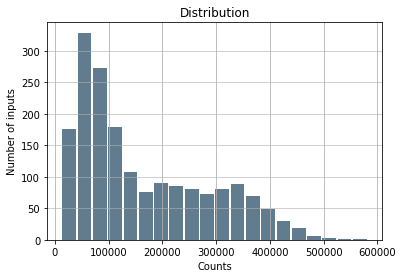

In [44]:
# get the distribution of the audio length (in 16k sample)
data_dist = pd.Series(audio_length_list)

data_dist.plot.hist(grid=True, bins=20, rwidth=0.9, color='#607c8e')
plt.title('Distribution')
plt.xlabel('Counts')
plt.ylabel('Number of inputs')
plt.grid(axis='y', alpha=0.75)

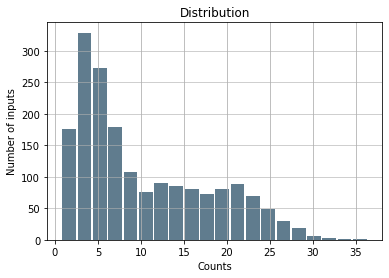

In [48]:
# get the distribution of the audio length (in 16k sample)
data_dist = pd.Series([audio_length/16000 for audio_length in audio_length_list])

data_dist.plot.hist(grid=True, bins=20, rwidth=0.9, color='#607c8e')
plt.title('Distribution')
plt.xlabel('Counts')
plt.ylabel('Number of inputs')
plt.grid(axis='y', alpha=0.75)

In [47]:
450000/16000

28.125